Cell 1: Setup & Imports

In [1]:
import os

# 1. Define your source and destination directories
source_directory = '/kaggle/input/bis_transformer/transformers/default/1'
destination_directory = '/kaggle/working/'


for filename in os.listdir(source_directory):
    
    source_path = os.path.join(source_directory, filename)

    if os.path.isfile(source_path):
        destination_path = os.path.join(destination_directory, filename)

        try:

            with open(source_path, 'rb') as source_file:
                content = source_file.read()
            with open(destination_path, 'wb') as destination_file:
                destination_file.write(content)
        except Exception as e:
            print(f"Error copying {filename}: {e}")



In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import glob

print("--- Libraries Imported ---v2")

2025-07-23 12:13:40.966604: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753272821.223347      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753272821.303392      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


--- Libraries Imported ---v2


Cell 2: Configuration

In [3]:
# config

# input path
INPUT_DATA_DIR = '/kaggle/input/vitaldb-preprocessed-data' 
MASTER_DATASET_PATH = os.path.join(INPUT_DATA_DIR, 'vitaldb_master_dataset.parquet')

# output path
OUTPUT_DIR = '/kaggle/working/'
SCALER_PATH = os.path.join(OUTPUT_DIR, 'final_scaler.joblib')
X_TRAIN_PATH = os.path.join(OUTPUT_DIR, 'X_train.npy')
Y_TRAIN_PATH = os.path.join(OUTPUT_DIR, 'y_train.npy')
X_VAL_PATH = os.path.join(OUTPUT_DIR, 'X_val.npy')
Y_VAL_PATH = os.path.join(OUTPUT_DIR, 'y_val.npy')
MODEL_SAVE_PATH = os.path.join(OUTPUT_DIR, 'small_transformer_best_model.keras')

# training parameters
SEQUENCE_LENGTH = 300
BATCH_SIZE = 512
EPOCHS = 5
LEARNING_RATE = 1e-4
VALIDATION_SPLIT_SIZE = 0.10    # 90% data for training and 10% for testing  
RANDOM_SEED = 42

print("--- Configuration Set ---v2")
print(f"Scaler will be saved to: {SCALER_PATH}")
print(f"Sequences will be saved to: {OUTPUT_DIR}")
print(f"Best model will be saved to: {MODEL_SAVE_PATH}")

--- Configuration Set ---v2
Scaler will be saved to: /kaggle/working/final_scaler.joblib
Sequences will be saved to: /kaggle/working/
Best model will be saved to: /kaggle/working/small_transformer_best_model.keras


Cell 3: Data Loading & Patient-Aware Splitting


In [4]:
print("--- Loading Master Dataset ---v2")
master_df = pd.read_parquet(MASTER_DATASET_PATH)

print(f"Loaded {len(master_df)} rows from {master_df['patient_id'].nunique()} patients.")

print("--- Performing Patient-Aware Split ---")
all_patient_ids = master_df['patient_id'].unique()

train_ids, val_ids = train_test_split(
    all_patient_ids,
    test_size=VALIDATION_SPLIT_SIZE,
    random_state=RANDOM_SEED
)

train_df = master_df[master_df['patient_id'].isin(train_ids)]
val_df = master_df[master_df['patient_id'].isin(val_ids)]

print(f"Training data: {len(train_df)} rows from {len(train_ids)} patients.")
print(f"Validation data: {len(val_df)} rows from {len(val_ids)} patients.")

del master_df

--- Loading Master Dataset ---v2
Loaded 44988566 rows from 3237 patients.
--- Performing Patient-Aware Split ---
Training data: 40635720 rows from 2913 patients.
Validation data: 4352846 rows from 324 patients.


Cell 4: Scaler Fitting (with Persistence)


In [5]:
feature_cols = ['Solar8000/HR', 'Solar8000/ART_MBP', 'Solar8000/PLETH_SPO2', 'Solar8000/ETCO2']

if os.path.exists(SCALER_PATH):
    print(f"--- Loading existing scaler from {SCALER_PATH} ---")
    scaler = joblib.load(SCALER_PATH)
else:
    print("--- Fitting new scaler ON TRAINING DATA ONLY ---v2")
    scaler = StandardScaler()
    scaler.fit(train_df[feature_cols])
    print(f"--- Saving scaler to {SCALER_PATH} ---")
    joblib.dump(scaler, SCALER_PATH)

--- Loading existing scaler from /kaggle/working/final_scaler.joblib ---


Cell 5: Sequence Generation


In [6]:
# --- Cell 5: High-Performance Ragged Tensor Pipeline (Pure Graph Windowing) ---

from tqdm.notebook import tqdm
import tensorflow as tf
import numpy as np

def calculate_steps_per_epoch(df, sequence_length, batch_size):
    """Calculates the number of steps per epoch."""
    total_sequences = 0
    grouped = df.groupby('patient_id')
    for _, group in tqdm(grouped, desc="Calculating total sequences", total=df['patient_id'].nunique()):
        if len(group) >= sequence_length:
            total_sequences += len(group) - sequence_length + 1
    steps = int(np.ceil(total_sequences / batch_size))
    return steps

def create_ragged_tensor_dataset(df, scaler, feature_cols, target_col, sequence_length, batch_size, shuffle=False):
    """
    The definitive high-performance pipeline.
    1. Manually constructs Ragged Tensors to avoid slow loading.
    2. Uses tf.signal.frame for pure, in-graph windowing, avoiding all sub-dataset overhead.
    """
    print(f"\n--- Building DEFINITIVE Ragged Tensor pipeline (shuffle={shuffle}) ---")
    df_scaled = df.copy()
    df_scaled[feature_cols] = scaler.transform(df[feature_cols])

    grouped = df_scaled.groupby('patient_id')
    all_patient_features = []
    all_patient_targets = []
    for _, group in tqdm(grouped, desc="Extracting patient data", total=df['patient_id'].nunique()):
        if len(group) < sequence_length:
            continue
        all_patient_features.append(group[feature_cols].values)
        all_patient_targets.append(group[target_col].values)

    print("--- Manually constructing Ragged Tensors ---")
    feature_values_list = [item for item in all_patient_features]
    target_values_list = [item for item in all_patient_targets]
    feature_row_splits = [0] + np.cumsum([len(p) for p in all_patient_features]).tolist()
    target_row_splits = [0] + np.cumsum([len(p) for p in all_patient_targets]).tolist()

    final_feature_values = np.concatenate(feature_values_list, axis=0).astype(np.float32)
    final_target_values = np.concatenate(target_values_list, axis=0).astype(np.float32)

    ragged_features = tf.RaggedTensor.from_row_splits(values=final_feature_values, row_splits=feature_row_splits)
    ragged_targets = tf.RaggedTensor.from_row_splits(values=final_target_values, row_splits=target_row_splits)

    dataset = tf.data.Dataset.from_tensor_slices((ragged_features, ragged_targets))

    # --- THE DEFINITIVE FIX: Pure Tensor-based windowing ---
    def create_sequences_from_tensors(features, targets):
        # Use tf.signal.frame to create windows directly from tensors. This is a single, fast C++ op.
        feature_sequences = tf.signal.frame(features, frame_length=sequence_length, frame_step=1, axis=0)

        # For targets, we need the value at the end of each sequence.
        # We can get this by windowing the 1D target tensor and taking the last element of each window.
        target_sequences = tf.signal.frame(targets, frame_length=sequence_length, frame_step=1, axis=0)
        target_labels = target_sequences[:, -1] # Take the last value of each sequence

        return tf.data.Dataset.from_tensor_slices((feature_sequences, target_labels))

    # flat_map now applies this highly efficient, pure-tensor function to each patient.
    dataset = dataset.flat_map(create_sequences_from_tensors)
    # --- END OF DEFINITIVE FIX ---

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1024*4)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

print("--- High-performance Ragged Tensor pipeline functions defined. ---v7 (Pure Graph Windowing)")

--- High-performance Ragged Tensor pipeline functions defined. ---v7 (Pure Graph Windowing)


Cell 6: Model Definition


In [7]:
# --- Cell 6: Model Definition & Simplified Callback ---

import json
import shutil
import os

# 1. SIMPLIFIED, ROBUST Resumable Checkpoint Callback
class ResumableCheckpoint(keras.callbacks.Callback):
    def __init__(self, filepath, state_filepath, save_freq, log_freq=500):
        super().__init__()
        self.filepath = filepath
        self.state_filepath = state_filepath
        self.save_freq = save_freq # How many batches between model saves
        self.log_freq = log_freq   # How many batches between log messages
        self.current_epoch = 0
        self.batches_seen_this_epoch = 0

    def on_epoch_begin(self, epoch, logs=None):
        # Store the current epoch (it's 0-indexed)
        self.current_epoch = epoch
        # Reset batch counter at the start of a new epoch
        self.batches_seen_this_epoch = 0

    def on_batch_end(self, batch, logs=None):
        # `batch` is the batch index within the current epoch
        self.batches_seen_this_epoch = batch + 1
        if self.batches_seen_this_epoch % self.log_freq == 0:
            loss = logs.get('loss', 'N/A'); mae = logs.get('mean_absolute_error', 'N/A')
            print(f"\n... Heartbeat: Reached Epoch {self.current_epoch + 1}, Batch {self.batches_seen_this_epoch}. Current loss: {loss:.4f}, MAE: {mae:.4f} ...")

        # Save a temporary model checkpoint periodically as a safeguard
        if self.batches_seen_this_epoch % self.save_freq == 0:
            print(f"\n--- Safeguard checkpoint: saving model at epoch {self.current_epoch + 1}, batch {self.batches_seen_this_epoch} ---")
            # Save to a temporary path to ensure atomicity
            root, ext = os.path.splitext(self.filepath)
            temp_filepath = root + '_temp' + ext
            self.model.save(temp_filepath)
            # Atomically move the file to the final destination
            shutil.move(temp_filepath, self.filepath)
            print("--- Safeguard checkpoint saved successfully. ---")

    def on_epoch_end(self, epoch, logs=None):
        """Saves the state to indicate that the next epoch should begin."""
        print(f"\n--- Epoch {epoch + 1} complete. Updating state file for resumption at Epoch {epoch + 2}. ---")
        # Save a state that indicates this epoch is done and the next one should start.
        # We use `epoch + 1` because the `epoch` argument is 0-indexed.
        state = {"epoch": epoch + 1}
        with open(self.state_filepath, 'w') as f:
            json.dump(state, f)
        print("--- State file updated for next epoch. ---")


# 2. Transformer Block Definition (Unchanged)
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([layers.Dense(ff_dim, activation="gelu"), layers.Dense(embed_dim)])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6); self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate); self.dropout2 = layers.Dropout(rate)
    def call(self, inputs, training=False):
        input_dtype = inputs.dtype; ln_input = self.layernorm1(inputs)
        attn_output = self.att(ln_input, ln_input)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = inputs + tf.cast(attn_output, dtype=input_dtype)
        ln_out1 = self.layernorm2(out1); ffn_output = self.ffn(ln_out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return out1 + tf.cast(ffn_output, dtype=input_dtype)

# 3. Model Builder (Unchanged)
def build_optimized_transformer_model(sequence_length, num_features):
    embed_dim=32; num_heads=4; ff_dim=128; num_blocks=2; dropout_rate=0.15
    print(f"\n--- Building OPTIMIZED model: embed_dim={embed_dim}, ff_dim={ff_dim}, num_heads={num_heads} ---")
    inputs = keras.Input(shape=(sequence_length, num_features)); x = layers.Dense(embed_dim)(inputs)
    for _ in range(num_blocks): x = TransformerBlock(embed_dim, num_heads, ff_dim, rate=dropout_rate)(x)
    x = layers.GlobalAveragePooling1D()(x); x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(16, activation="gelu")(x); outputs = layers.Dense(1, dtype='float32')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    print(f"Model created with ~{model.count_params():,} parameters."); return model

print("--- Optimized model architecture and SIMPLIFIED ResumableCheckpoint defined ---v3")

--- Optimized model architecture and SIMPLIFIED ResumableCheckpoint defined ---v3


Cell 7: Training


In [8]:
# --- Cell 7: High-Performance & Resumable Training (Final Tuning) ---

RESUMABLE_MODEL_PATH = os.path.join(OUTPUT_DIR, 'resumable_checkpoint.keras')
STATE_FILE_PATH = os.path.join(OUTPUT_DIR, 'training_state.json')

# --- Step 1: Handle Resumption State ---
initial_epoch = 0
model = None # Initialize model as None

if os.path.exists(STATE_FILE_PATH) and os.path.exists(RESUMABLE_MODEL_PATH):
    print(f"--- Found existing checkpoint. Resuming training. ---")
    with open(STATE_FILE_PATH, 'r') as f:
        state = json.load(f)
    initial_epoch = state.get('epoch', 0)

    print(f"--- Resuming from epoch {initial_epoch + 1}. ---")
    model = keras.models.load_model(RESUMABLE_MODEL_PATH, custom_objects={"TransformerBlock": TransformerBlock})
else:
    print("--- No existing checkpoint found. Starting from scratch. ---")


# --- Step 2: Calculate Steps Per Epoch BEFORE creating datasets ---
# This is now CRITICAL for performance.
print("--- Pre-calculating steps per epoch for train and validation sets... ---")
train_steps = calculate_steps_per_epoch(train_df, SEQUENCE_LENGTH, BATCH_SIZE)
val_steps = calculate_steps_per_epoch(val_df, SEQUENCE_LENGTH, BATCH_SIZE)
print(f"--- Calculated {train_steps} train steps and {val_steps} validation steps per epoch. ---")


# --- Step 3: Create the Data Pipelines ---
print("\n--- Creating high-performance in-graph datasets... ---")
train_dataset = create_ragged_tensor_dataset(
    train_df, scaler, feature_cols, 'BIS/BIS', SEQUENCE_LENGTH, BATCH_SIZE, shuffle=True
)
val_dataset = create_ragged_tensor_dataset(
    val_df, scaler, feature_cols, 'BIS/BIS', SEQUENCE_LENGTH, BATCH_SIZE
)
print("\n--- tf.data in-graph pipelines created successfully. ---")
del train_df, val_df


# --- Step 4: Build Model if Needed ---
if model is None:
    print("--- Building new model from scratch. ---")
    model = build_optimized_transformer_model(SEQUENCE_LENGTH, len(feature_cols))


# --- Step 5: Compile and Train ---
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Define LR schedule using the pre-calculated steps
total_steps_for_lr = train_steps * EPOCHS
warmup_steps = int(total_steps_for_lr * 0.1)
print(f"--- LR Schedule: Total Steps={total_steps_for_lr}, Warmup Steps={warmup_steps} ---")

lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=total_steps_for_lr - warmup_steps,
    end_learning_rate=0.0,
    power=1.0
)

optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=0.01)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
model.summary()

# Define Callbacks
best_model_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_SAVE_PATH, monitor='val_loss', save_best_only=True, mode='min', verbose=1
)
resumable_checkpoint = ResumableCheckpoint(
    filepath=RESUMABLE_MODEL_PATH, state_filepath=STATE_FILE_PATH, save_freq=2000, log_freq=500
)
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=2, restore_best_weights=True, verbose=1
)

print(f"\n--- Starting FULLY OPTIMIZED & RESUMABLE Training ---")
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[best_model_checkpoint, resumable_checkpoint, early_stopping],
    initial_epoch=initial_epoch,
    steps_per_epoch=train_steps,       # <-- CRITICAL FIX
    validation_steps=val_steps         # <-- CRITICAL FIX
)

--- No existing checkpoint found. Starting from scratch. ---
--- Pre-calculating steps per epoch for train and validation sets... ---


Calculating total sequences:   0%|          | 0/2913 [00:00<?, ?it/s]

Calculating total sequences:   0%|          | 0/324 [00:00<?, ?it/s]

--- Calculated 77666 train steps and 8313 validation steps per epoch. ---

--- Creating high-performance in-graph datasets... ---

--- Building DEFINITIVE Ragged Tensor pipeline (shuffle=True) ---


Extracting patient data:   0%|          | 0/2913 [00:00<?, ?it/s]

--- Manually constructing Ragged Tensors ---


I0000 00:00:1753272852.554493      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



--- Building DEFINITIVE Ragged Tensor pipeline (shuffle=False) ---


Extracting patient data:   0%|          | 0/324 [00:00<?, ?it/s]

--- Manually constructing Ragged Tensors ---

--- tf.data in-graph pipelines created successfully. ---
--- Building new model from scratch. ---

--- Building OPTIMIZED model: embed_dim=32, ff_dim=128, num_heads=4 ---
Model created with ~51,265 parameters.
--- LR Schedule: Total Steps=388330, Warmup Steps=38833 ---


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 300, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300, 32)        │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 300, 32)        │        25,280 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 300, 32)        │        25,280 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,265 (200.25 KB)

 Trainable params: 51,265 (200.25 KB)

 Non-trainable params: 0 (0.00 B)


--- Starting FULLY OPTIMIZED & RESUMABLE Training ---
Epoch 1/5


I0000 00:00:1753272869.488497      63 service.cc:148] XLA service 0x78e76800abe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753272869.489371      63 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753272870.489421      63 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1753272876.368184      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  499/77666 ━━━━━━━━━━━━━━━━━━━━ 1:59:16 93ms/step - loss: 1361.9092 - mean_absolute_error: 33.2654
... Heartbeat: Reached Epoch 1, Batch 500. Current loss: 891.0670, MAE: 24.4528 ...
  999/77666 ━━━━━━━━━━━━━━━━━━━━ 1:58:22 93ms/step - loss: 1020.4475 - mean_absolute_error: 26.5803
... Heartbeat: Reached Epoch 1, Batch 1000. Current loss: 560.5881, MAE: 17.3811 ...
 1499/77666 ━━━━━━━━━━━━━━━━━━━━ 1:57:32 93ms/step - loss: 847.1587 - mean_absolute_error: 23.0600
... Heartbeat: Reached Epoch 1, Batch 1500. Current loss: 450.2608, MAE: 14.8859 ...
 1999/77666 ━━━━━━━━━━━━━━━━━━━━ 1:56:45 93ms/step - loss: 741.8104 - mean_absolute_error: 20.9281
... Heartbeat: Reached Epoch 1, Batch 2000. Current loss: 401.5424, MAE: 14.0638 ...

--- Safeguard checkpoint: saving model at epoch 1, batch 2000 ---
--- Safeguard checkpoint saved successfully. ---
 2499/77666 ━━━━━━━━━━━━━━━━━━━━ 1:56:02 93ms/step - loss: 669.9583 - mean_absolute_error: 19.4794
... Heartbeat: Reached Epoch 1, Batch 2500. Curr

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 189.66585

--- Epoch 2 complete. Updating state file for resumption at Epoch 3. ---
--- State file updated for next epoch. ---
77666/77666 ━━━━━━━━━━━━━━━━━━━━ 314s 4ms/step - loss: 0.0000e+00 - mean_absolute_error: 0.0000e+00 - val_loss: 189.6658 - val_mean_absolute_error: 9.1430
Epoch 3/5
  499/77666 ━━━━━━━━━━━━━━━━━━━━ 1:59:59 93ms/step - loss: 191.6489 - mean_absolute_error: 9.3732
... Heartbeat: Reached Epoch 3, Batch 500. Current loss: 248.6625, MAE: 10.7168 ...
  999/77666 ━━━━━━━━━━━━━━━━━━━━ 1:58:58 93ms/step - loss: 207.7152 - mean_absolute_error: 9.6984
... Heartbeat: Reached Epoch 3, Batch 1000. Current loss: 220.0594, MAE: 9.8824 ...
 1499/77666 ━━━━━━━━━━━━━━━━━━━━ 1:58:10 93ms/step - loss: 210.0535 - mean_absolute_error: 9.6871
... Heartbeat: Reached Epoch 3, Batch 1500. Current loss: 207.7812, MAE: 9.4282 ...
 1999/77666 ━━━━━━━━━━━━━━━━━━━━ 1:57:22 93ms/step - loss: 211.0954 - mean_absolute_error: 9.7050
... Heartbeat: Reached E

Cell 8: Evaluation



--- Evaluating Final Model Performance ---
--- Loading best model from /kaggle/working/small_transformer_best_model.keras ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'transformer_block', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'transformer_block_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_o

--- Generating predictions on validation set... ---
8313/8313 ━━━━━━━━━━━━━━━━━━━━ 244s 29ms/step
--- Extracting true labels for comparison... ---

--- Final Model Evaluation on Validation Set ---
  Mean Absolute Error (MAE): 9.1429
  Mean Squared Error (MSE):  189.6676
  R-squared (R²):            0.1929
-------------------------------------------------


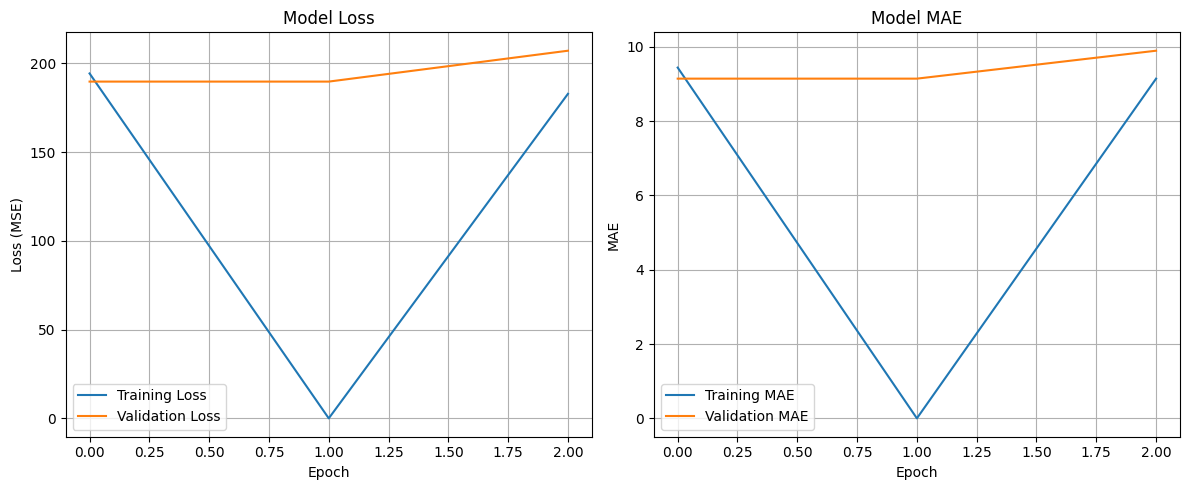

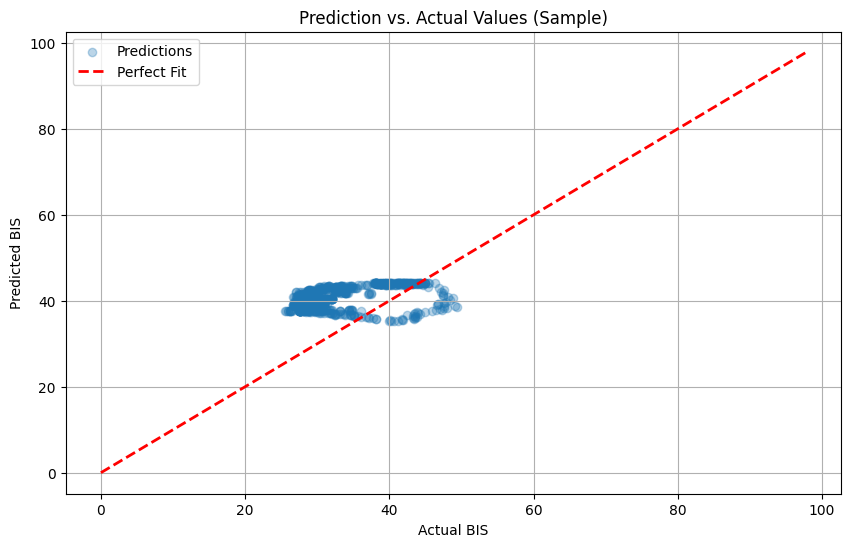

In [9]:
from sklearn.metrics import r2_score

print("\n--- Evaluating Final Model Performance ---")

# load best model
print(f"--- Loading best model from {MODEL_SAVE_PATH} ---")
loaded_model = keras.models.load_model(
    MODEL_SAVE_PATH,
    custom_objects={"TransformerBlock": TransformerBlock}
)

# make predictions on validation set
print("--- Generating predictions on validation set... ---")
y_pred = loaded_model.predict(val_dataset)

print("--- Extracting true labels for comparison... ---")
y_true = np.concatenate([y for x, y in val_dataset], axis=0)

y_pred = y_pred[:len(y_true)]

final_mae = np.mean(np.abs(y_true - y_pred.squeeze()))
final_mse = np.mean((y_true - y_pred.squeeze())**2)
final_r2 = r2_score(y_true, y_pred)

print("\n--- Final Model Evaluation on Validation Set ---")
print(f"  Mean Absolute Error (MAE): {final_mae:.4f}")
print(f"  Mean Squared Error (MSE):  {final_mse:.4f}")
print(f"  R-squared (R²):            {final_r2:.4f}")
print("-------------------------------------------------")

# plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss'); plt.ylabel('Loss (MSE)'); plt.xlabel('Epoch')
plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model MAE'); plt.ylabel('MAE'); plt.xlabel('Epoch')
plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

# plot predictions vs actual
plt.figure(figsize=(10, 6))
sample_size = min(1000, len(y_true))
plt.scatter(y_true[:sample_size], y_pred[:sample_size], alpha=0.3, label='Predictions')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', lw=2, label='Perfect Fit')
plt.title('Prediction vs. Actual Values (Sample)'); plt.xlabel('Actual BIS'); plt.ylabel('Predicted BIS')
plt.legend(); plt.grid(True)
plt.show()